In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import time

In [3]:
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, losses
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report


In [4]:
train_images = []
train_labels = []
test_images = []
test_labels = []

In [5]:
for category in range(4):
    images = [img_to_array(load_img(f'/content/drive/My Drive/Myocardial Infraction CNN/{category}/{file}', color_mode='grayscale', target_size=(90, 120))) for file in os.listdir(f'/content/drive/My Drive/Myocardial Infraction CNN/{category}')]

    labels = [category] * len(images)

    train_images_category, test_images_category, train_labels_category, test_labels_category = train_test_split(images, labels, test_size=0.2)

    train_images.extend(train_images_category)
    test_images.extend(test_images_category)
    train_labels.extend(train_labels_category)
    test_labels.extend(test_labels_category)

In [6]:
x_train = np.array(train_images)
x_test = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [7]:
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

In [8]:
start_time = time.time()


In [9]:
cnn_model = tf.keras.Sequential([
    layers.Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

In [10]:
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 90, 120, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 45, 60, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 60, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 30, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 22080)             0         
                                                                 
 dense (Dense)               (None, 64)                1

In [12]:
history = cnn_model.fit(x_train, train_labels, epochs=100, validation_data=(x_test, test_labels))

Epoch 1/100
24/24 [==============================] - 4s 29ms/step - loss: 1.4321 - accuracy: 0.2861 - val_loss: 1.3790 - val_accuracy: 0.2513
Epoch 2/100
24/24 [==============================] - 0s 9ms/step - loss: 1.3834 - accuracy: 0.2591 - val_loss: 1.3794 - val_accuracy: 0.2513
Epoch 3/100
24/24 [==============================] - 0s 8ms/step - loss: 1.3750 - accuracy: 0.3131 - val_loss: 1.3737 - val_accuracy: 0.2567
Epoch 4/100
24/24 [==============================] - 0s 9ms/step - loss: 1.3419 - accuracy: 0.3779 - val_loss: 1.2763 - val_accuracy: 0.3690
Epoch 5/100
24/24 [==============================] - 0s 8ms/step - loss: 1.1973 - accuracy: 0.4858 - val_loss: 1.0701 - val_accuracy: 0.6257
Epoch 6/100
24/24 [==============================] - 0s 8ms/step - loss: 0.9127 - accuracy: 0.7045 - val_loss: 0.9310 - val_accuracy: 0.5775
Epoch 7/100
24/24 [==============================] - 0s 10ms/step - loss: 0.6926 - accuracy: 0.7422 - val_loss: 0.8320 - val_accuracy: 0.6952
Epoch 8/100

6/6 [==============================] - 0s 5ms/step - loss: 106.5831 - accuracy: 0.8770


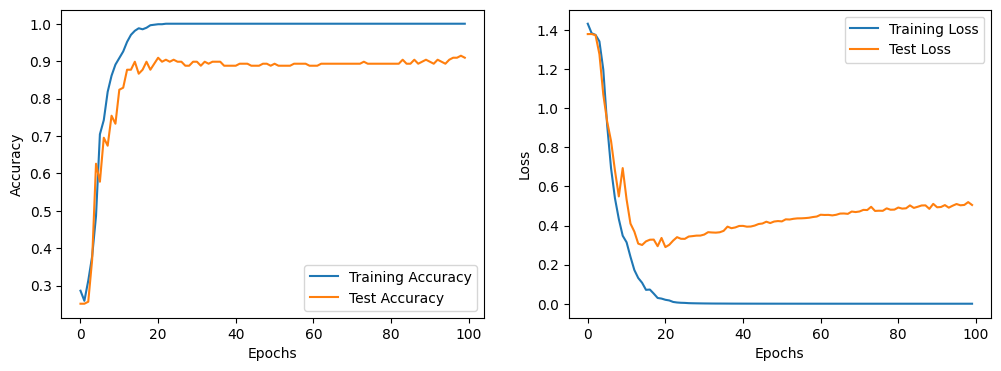

In [13]:
test_loss, test_acc = cnn_model.evaluate(np.array(test_images), np.array(test_labels))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [14]:
predictions = cnn_model.predict(np.array(test_images))
binary_predictions = np.argmax(predictions, axis=1)
test_labels = test_labels.reshape(-1, 1)
conf_matrix = confusion_matrix(test_labels, binary_predictions)

6/6 [==============================] - 0s 3ms/step


In [15]:
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
precision = np.diagonal(conf_matrix) / np.sum(conf_matrix, axis=0)
recall = np.diagonal(conf_matrix) / np.sum(conf_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)


num_classes = len(conf_matrix)
specificity = []
for i in range(num_classes):
    true_negatives = np.sum(conf_matrix) - np.sum(conf_matrix[i, :]) - np.sum(conf_matrix[:, i]) + conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    specificity_class = true_negatives / (true_negatives + false_positives)
    specificity.append(specificity_class)

average_specificity = np.mean(specificity)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"Specificity for each class: {specificity}")
print(f"Average Specificity: {average_specificity}")

Confusion Matrix:
[[48  0  0  0]
 [ 2 32  7  6]
 [ 2  2 29  2]
 [ 0  2  0 55]]
Accuracy: 0.8770
Precision: [0.92307692 0.88888889 0.80555556 0.87301587]
Recall: [1.         0.68085106 0.82857143 0.96491228]
F1 Score: [0.96       0.77108434 0.81690141 0.91666667]
Specificity for each class: [0.9712230215827338, 0.9714285714285714, 0.9539473684210527, 0.9384615384615385]
Average Specificity: 0.9587651249734741


In [16]:
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time} seconds.")

Training took 30.756741762161255 seconds.
